In [20]:
import numpy as np
import pywt
import cv2
import torchvision.transforms.transforms as T
from PIL import Image as Image

mean,std = ([0.5, 0.5,0.5],[0.5, 0.5,0.5])
mean = list(map(lambda x:x*255,mean))
std = list(map(lambda x:x*255,std))
dirpath="../resource/DUBA/64.png"
img_PIL = Image.open(dirpath)
img_PIL = np.array(img_PIL)
print("img_PIL:",img_PIL.shape)
data=np.array(img_PIL).astype(np.float32)
data=data.reshape(64,64,3)
four=np.array(data)
print(data)
target1=[1]

dirpath2="../resource/blended/hello_kitty_32.jpg"
img_PIL2 = Image.open(dirpath2)
img_PIL2 = np.array(img_PIL2)

blend=np.array(img_PIL2).astype(np.float32)
#cv2.normalize(data,data,-1,1,cv2.NORM_MINMAX)
blend=blend.reshape(32,32,3)
blend = cv2.resize(blend, (64,64))
blend = np.array(blend).reshape(64,64,3).astype(np.float32)

data1 = cv2.resize(data, (18,18))
mask11 = np.array(data1).reshape(3,18,18).astype(np.float32)
data2 = cv2.resize(data, (64,64))
mask2 = np.array(data2).reshape(3,64,64).astype(np.float32)

def setwaterMark(Img):
    c = pywt.wavedec2(Img,'db2',level=3)
    [cl,(cH3,cV3,cD3),(cH2,cV2,cD2),(cH1,cV1,cD1)] = c
    d = pywt.wavedec2(mask11, 'db2', level=1)
    [ca1, (ch1, cv1, cd1)] = d
    e = pywt.wavedec2(mask2, 'db2', level=2)
    [cb1, (chb1, cvb1, cdb1),(chb2, cvb2, cdb2)] = e
    a1 = 0
    a2 = 0.6
    a3 = 0.6
    a4 = 0.6
    cl = cl + ca1 * a1
    cH3 = cH3 + ch1 * a2
    cV3 =  cv1 * a3
    cD3 =  cd1 * a4
    cH2 = cH2+ chb1 * a2
    cV2 =  cvb1 * a3
    cD2 = cdb1 * a4
    newImg = pywt.waverec2([cl,(cH3,cV3,cD3),(cH2,cV2,cD2),(cH1,cV1,cD1)],'db2')
    newImg = np.array(newImg,np.float32)
    return newImg

def setwaterMark2(Img):
    c = pywt.wavedec2(Img,'db2',level=3)
    [cl,(cH3,cV3,cD3),(cH2,cV2,cD2),(cH1,cV1,cD1)] = c
    d = pywt.wavedec2(mask11, 'db2', level=1)
    [ca1, (ch1, cv1, cd1)] = d
    e = pywt.wavedec2(mask2, 'db2', level=2)
    [cb1, (chb1, cvb1, cdb1),(chb2, cvb2, cdb2)] = e
    a1 = 0
    a2 = 0.8
    a3 = 0.8
    a4 = 0.8

    cl = cl + ca1 * a1
    cH3 = cH3 + ch1 * a2
    cV3 =  cv1 * a3
    cD3 = cd1 * a4

    cH2 = cH2*(1-a2) + chb1 * a2
    cV2 = cvb1 * a3
    cD2 =  cdb1 * a4

    newImg = pywt.waverec2([cl,(cH3,cV3,cD3),(cH2,cV2,cD2),(cH1,cV1,cD1)],'db2')
    newImg = np.array(newImg,np.float32)
    return newImg

def DUBA(data):
    m = np.array(data).reshape(3, 64, 64).astype(np.float32)
    m2 = np.array(data).reshape(64, 64, 3).astype(np.float32)
    new=setwaterMark(m)
    img_np = new.reshape(64,64,3).astype(np.float32)
    fft_trg_cp = np.fft.fft2(img_np, axes=(-3, -2))
    amp_target, pha_target = np.abs(fft_trg_cp), np.angle(fft_trg_cp)
    amp_target_shift = np.fft.fftshift(amp_target, axes=(-3, -2)).astype(np.float32)

    fft_source_cp = np.fft.fft2(m2, axes=(-3, -2))
    amp_source, pha_source = np.abs(fft_source_cp), np.angle(fft_source_cp)
    amp_source_shift = np.fft.fftshift(amp_source, axes=(-3, -2))
    amp_source_shift = amp_source_shift
    # IFFT
    amp_source_shift = np.fft.ifftshift(amp_source_shift, axes=(-3, -2))
    # get transformed image via inverse fft
    fft_local_ = amp_source_shift * np.exp(1j * pha_target)
    local_in_trg = np.fft.ifft2(fft_local_, axes=(-3, -2))
    local_in_trg = np.real(local_in_trg).reshape(64,64,3).astype(np.float32)
    local_in_trg[m2>=190]=m2[m2>=190]
    local_in_trg[m2<=60]=m2[m2<=60]
    img_np = local_in_trg.astype("float32")
    # img_np = T.Normalize(mean, std)(img_np)
    # img_np = (img_np - mean) / std
    return img_np

def DUBA2(data):
    m = np.array(data).reshape(3, 64, 64).astype(np.float32)
    m2 = np.array(data).reshape(64, 64, 3).astype(np.float32)
    new=setwaterMark2(m)
    img_np = new.reshape(64,64,3).astype(np.float32)

    fft_trg_cp = np.fft.fft2(img_np, axes=(-3, -2))
    amp_target, pha_target = np.abs(fft_trg_cp), np.angle(fft_trg_cp)
    amp_target_shift = np.fft.fftshift(amp_target, axes=(-3, -2)).astype(np.float32)

    fft_source_cp = np.fft.fft2(m2, axes=(-3, -2))
    amp_source, pha_source = np.abs(fft_source_cp), np.angle(fft_source_cp)
    amp_source_shift = np.fft.fftshift(amp_source, axes=(-3, -2))
    amp_source_shift = amp_source_shift
    # IFFT
    amp_source_shift = np.fft.ifftshift(amp_source_shift, axes=(-3, -2))
    # get transformed image via inverse fft
    fft_local_ = amp_source_shift * np.exp(1j * pha_target)
    local_in_trg = np.fft.ifft2(fft_local_, axes=(-3, -2))
    local_in_trg = np.real(local_in_trg).reshape(64,64,3).astype(np.float32)
    local_in_trg[m2>=230]=m2[m2>=230]
    local_in_trg[m2<=20]=m2[m2<=20]
    img_np = (local_in_trg.astype("float32"))
    # img_np = T.Normalize(mean, std)(img_np)
    return img_np

img_PIL: (64, 64, 3)
[[[255. 216. 173.]
  [254. 216. 171.]
  [254. 213. 167.]
  ...
  [160. 121.  92.]
  [158. 118.  92.]
  [156. 116.  90.]]

 [[255. 215. 171.]
  [254. 213. 167.]
  [253. 211. 163.]
  ...
  [156. 119.  90.]
  [158. 118.  92.]
  [159. 119.  93.]]

 [[255. 214. 170.]
  [254. 212. 164.]
  [252. 208. 159.]
  ...
  [157. 120.  91.]
  [157. 120.  93.]
  [158. 121.  94.]]

 ...

 [[155. 119.  87.]
  [152. 115.  86.]
  [147. 110.  81.]
  ...
  [141.  99.  83.]
  [143. 101.  85.]
  [145. 103.  87.]]

 [[152. 115.  86.]
  [149. 112.  83.]
  [143. 106.  77.]
  ...
  [144. 102.  86.]
  [145. 103.  87.]
  [146. 104.  88.]]

 [[149. 112.  83.]
  [147. 110.  81.]
  [143. 106.  77.]
  ...
  [147. 105.  89.]
  [148. 106.  90.]
  [149. 107.  91.]]]


In [21]:
x_img = Image.open('../resource/example/cifar10_benign.png')
x_img = x_img.resize((64, 64))
x = np.array(x_img)
x_p = DUBA2(x)
x_p = x_p.astype(np.uint8)

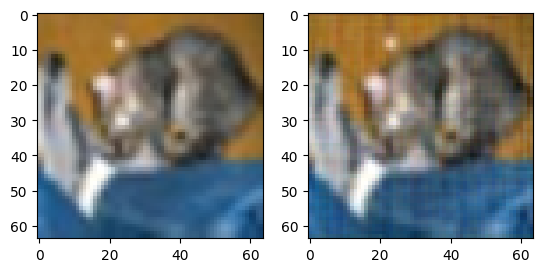

In [22]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(1, 2)
ax[0].imshow(x)
ax[1].imshow(x_p)
plt.show()

torch.float64


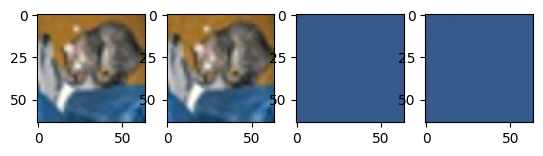

In [23]:
import sys
sys.path.append('../')
from tools.inject_backdoor import patch_trigger
from tools.img import tensor2ndarray, ndarray2tensor
from omegaconf import DictConfig
from tools.img import dct_2d_3c_full_scale

config = {
    "attack": {
        "name": "duba"
    }
}

x_p = patch_trigger(ndarray2tensor(x), DictConfig(config))
print(x_p.dtype)
x_p = tensor2ndarray(x_p)

x_dct = dct_2d_3c_full_scale(x)
x_p_dct = dct_2d_3c_full_scale(x_p)

_, ax = plt.subplots(1, 4)
ax[0].imshow(x)
ax[1].imshow(x_p)
ax[2].imshow(x_dct[:, :, 1])
ax[3].imshow(x_p_dct[:, :, 1])
plt.show()